# GATE (Sinogram Reconstruction; No Time of Flight)

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETSinogramPolygonProjMeta
from pytomography.projectors.PET import PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import sss
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt

First we'll load all required objects for performing PET reconstruction:

In [2]:
path = '/disk1/pet_mri_scan/'
# Macro path where PET scanner geometry file is defined
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Get information dictionary about the scanner
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
# Paths to all ROOT files containing data
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 55)]; del(paths[23]) #path 23 corrupted

We can look at the information of our PET scanner:

In [3]:
info

{'min_rsector_difference': 0,
 'crystal_length': 20.0,
 'radius': 337.0,
 'crystalTransNr': 8,
 'crystalTransSpacing': 4.0,
 'crystalAxialNr': 8,
 'crystalAxialSpacing': 4.0,
 'submoduleAxialNr': 1,
 'submoduleAxialSpacing': 0,
 'submoduleTransNr': 1,
 'submoduleTransSpacing': 0,
 'moduleTransNr': 1,
 'moduleTransSpacing': 0.0,
 'moduleAxialNr': 8,
 'moduleAxialSpacing': 32.25,
 'rsectorTransNr': 56,
 'rsectorAxialNr': 1,
 'NrCrystalsPerRing': 448,
 'NrRings': 64,
 'firstCrystalAxis': 1}

## Normalization Correction

In PET imaging, each detector crystal used in the scanner will have a different response to a uniform source due to its positioning (e.g. crystals at the end of edge of modules are different than those in the center). Adequate PET reconstruction takes this into account by first performing a calibration scan for a scanner and obtaining a normalization correction factor for each crystal pair LOR

**The cell below only needs to be ran once**, and may take a long time, as it requires opening and parsing through all the ROOT files corresponding to the normalization scan. Once it is ran, the normalization weights corresponding to each pair of detector IDs will be obtained (due to geometry/crystal orientation).

 This particular calibration scan was done using a thin cylindrical shell. We can compute $\eta$ using a particular function in the gate functionality of PyTomography. Then we save it as a `torch.Tensor` file for easy access in the next part. For this we need

* `cylinder_radius`: The radius of the thin cylindrical shell used for calibration

In [ ]:
normalization_paths = [os.path.join(path, f'normalization_scan/mMR_Norm_{i}.root') for i in range(1,37)]

# Get eta in listmode format
normalization_weights = gate.get_normalization_weights_cylinder_calibration(
    normalization_paths,
    info,
    cylinder_radius = 320, # mm (radius of calibration cylindrical shell
    include_randoms=False 
)

normalization_sinogram = gate.get_norm_sinogram_from_listmode_data(normalization_weights, info)
torch.save(normalization_sinogram, os.path.join(path, 'normalization_sinogram.pt'))

Once the cell above has been ran once, it can be opened as follows:

In [4]:
normalization_sinogram = torch.load(os.path.join(path, 'normalization_sinogram.pt'))

## Primary-Only Reconstruction

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data. We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters). PyTomography always begins by opening listmode events that yield pairs of detector IDs for each detected event.

In [5]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids = gate.get_detector_ids_from_root(
    paths,
    info,
    include_randoms=False,
    include_scatters=False)
torch.save(detector_ids, os.path.join(path, 'detector_ids_primary_only.pt'))

In [6]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids = torch.load(os.path.join(path, 'detector_ids_primary_only.pt'))

Lets also get the true scatters and randoms from this data so we can compare our estimation later on

In [ ]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids_randoms_true = gate.get_detector_ids_from_root(
    paths,
    info,
    randoms_only=True)
detector_ids_scatters_true = gate.get_detector_ids_from_root(
    paths,
    info,
    scatters_only=True)
torch.save(detector_ids_randoms_true, os.path.join(path, 'detector_ids_randoms_true.pt'))
torch.save(detector_ids_scatters_true, os.path.join(path, 'detector_ids_scatters_true.pt'))

In [7]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids_randoms_true = torch.load(os.path.join(path, 'detector_ids_randoms_true.pt'))
detector_ids_scatters_true = torch.load(os.path.join(path, 'detector_ids_scatters_true.pt'))

We can convert the loaded listmode events into sinogram format using the following:
* Note: PyTomography currently only has basic sinogram binning functionality with no mashing / data reduction

In [8]:
sinogram = gate.listmode_to_sinogram(detector_ids, info)

We reconstruct as follows:

In [9]:
# Specify object space for reconstruction
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
# Get projection space metadata from PET geometry information dictionary
proj_meta = PETSinogramPolygonProjMeta(info)
# Get attenuation map and PSF transform from the associated phantom
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
psf_transform = GaussianFilter(4) # 4mm gaussian blurring
# Create system matrix
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       sinogram_sensitivity = normalization_sinogram,
       N_splits=10, # Split FP/BP into 10 loops to save memory
       attenuation_map=atten_map,
       device='cpu' # projections are output on the CPU, but internal computation is on GPU
)
# Create likelihood 
likelihood = PoissonLogLikelihood(
    system_matrix,
    sinogram,
)
# Initialize reconstruction algorithm
recon_algorithm = OSEM(likelihood)
# Reconstruct
recon_primaryonly = recon_algorithm(n_iters=2, n_subsets=24)

And plot:

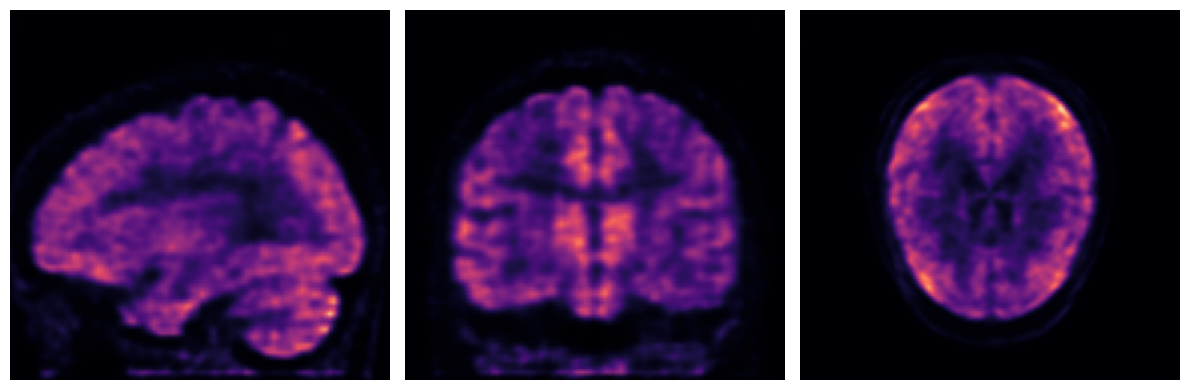

In [10]:
vmax = 0.15
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

Note that this is not possible in clinical practice, since we don't know which events are scatters/randoms. The reconstruction above is going to be used as an "ideal" comparison for our reconstruction of all events.

## Reconstruction Correcting For Randoms + Scatters

For reconstruction of all events, we need to estimate boths randoms and scatters. Lets now get **all** events that were obtained in GATE:

In [ ]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids = gate.get_detector_ids_from_root(
    paths,
    info)
torch.save(detector_ids, os.path.join(path, 'detector_ids_all_events.pt'))

In [10]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids = torch.load(os.path.join(path, 'detector_ids_all_events.pt'))

Load the sinogram of all events:

In [11]:
sinogram = gate.listmode_to_sinogram(detector_ids, info)

### Randoms

PyTomography has functionality to estimate random events via delayed coincidences. We can obtained the delayed coincidence random events from GATE data as follows:

In [ ]:
# RUN IF YOU HAVEN'T RAN BEFORE
detector_ids_delays = gate.get_detector_ids_from_root(
    paths,
    info,
    substr = 'delay')
torch.save(detector_ids_delays, os.path.join(path, 'detector_ids_delays.pt'))

In [12]:
# RUN IF YOU'VE ALREADY RAN THE CELL ABOVE
detector_ids_delays= torch.load(os.path.join(path, 'detector_ids_delays.pt'))

In [13]:
sinogram_delays = gate.listmode_to_sinogram(detector_ids_delays, info)

Let's plot the sinogram of estimated randoms ($r-z$ plane corresponding to $\theta=0$ and a ring difference of 0)

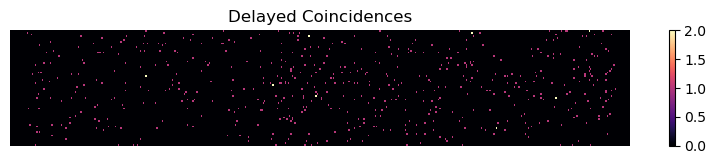

In [14]:
plt.figure(figsize=(10,1.5))
plt.pcolormesh(sinogram_delays[0,:,:64].T, cmap='magma')
plt.title('Delayed Coincidences')
plt.axis('off')
plt.colorbar()

As can be seen, the data is very sparse, and is not a good estimation of randoms in all bins. In order to make this a good estimation of randoms, we can smooth the sinogram:

In [15]:
sinogram_randoms_estimate = gate.smooth_randoms_sinogram(sinogram_delays, info, sigma_r=4, sigma_theta=4, sigma_z=4)

Let's look at the interpolated sinogram, and compare it to the real randoms:

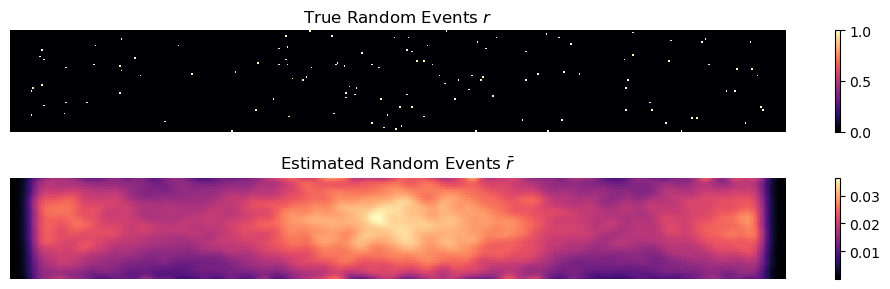

In [16]:
sinogram_randoms_true = gate.listmode_to_sinogram(detector_ids_randoms_true, info)

fig = plt.figure(figsize=(10,3))
plt.subplot(211)
plt.pcolormesh(sinogram_randoms_true[0,:,:64].T, cmap='magma')
plt.title('True Random Events $r$')
plt.axis('off')
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(sinogram_randoms_estimate[0,:,:64].T, cmap='magma')
plt.title(r'Estimated Random Events $\bar{r}$')
plt.axis('off')
plt.colorbar()
fig.tight_layout()
plt.show()

# Delete to save memory
del(sinogram_randoms_true)

Note that the delayed coincidences are intended to yield the mean random rate $\bar{r}$ in each bin; the top plot yields a particular noise realization.

### Scatters

PyTomography estimates scatters via the single scatter simulation (SSS) algorithm (w or w/o time of flight). In order to use SSS, we need an initial reconstruction of the data (without scatter estimation). We use this reconstruction as a proxy to estimate scatter. Let's first reconstruct the data without scatter estimation (but using randoms):

In [17]:
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
normalization_sinogram = torch.load(os.path.join(path, 'normalization_sinogram.pt')) # assumes this has been saved from the intro tutorial
proj_meta = PETSinogramPolygonProjMeta(info)
psf_transform = GaussianFilter(4)
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       sinogram_sensitivity = normalization_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, rest is GPU
)

We'll reconstruct only using randoms as an estimate. We need to pass the random sinogram estimate divided by the sensitivty sinogram as an additive term estimate to the likelihood function:

In [18]:
additive_term = sinogram_randoms_estimate / system_matrix._compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )

Now we reconstruct using only random estimation

In [19]:
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(2,24)

This reconstruction is then used to estimate scatter in the SSS scatter estimation technique. The parameters are discussed below the code cell below

In [20]:
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = sinogram,
    image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_randoms_estimate
    )

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Besides the obvious parameters:

* `pet_image` is the initial activity estimation which is used to estimate the scatter contribution. Note that although the activity is much higher here than the scatter-corrected image, the scatter is not over predicted since it is scaled to the tails at the end (discussed below)
* `attenuation_image` is used to compute compton cross sections
* `system_matrix` is needed for the scaling of the scatter tails.
* `proj_data` is required for the scaling of the scatter tails.
* `image_stepsize` is the stepsize in x/y/z used for subsampling voxels in object space for the scatter simulation.
* `attenuation_cutoff` is used for two purposes: (i) any scatter point below this value is not considered and (ii) when the attenuation map is forward projected as a mask to scale the scatter tails, this is the cutoff value for the mask
* `sinogram_interring_stepsize`: the axial (between rings) stepsize between detector crystals used as sample points in the scatter simulation
* `sinogram_intrraring_stepsize`: the transaxial stepsize between detector crystals used as sample points in the scatter simulation.
* `sinogram_random`: required for scaling the scatter tails at the end.

The SSS essentially works as follows: 

(i) Compute scatter estimation in sparse sinogram space (only certain detector crystals considered)
(ii) Interpolate sinogram
(iii) Scale scatter tails

Lets compare this to the true scatter distribution:



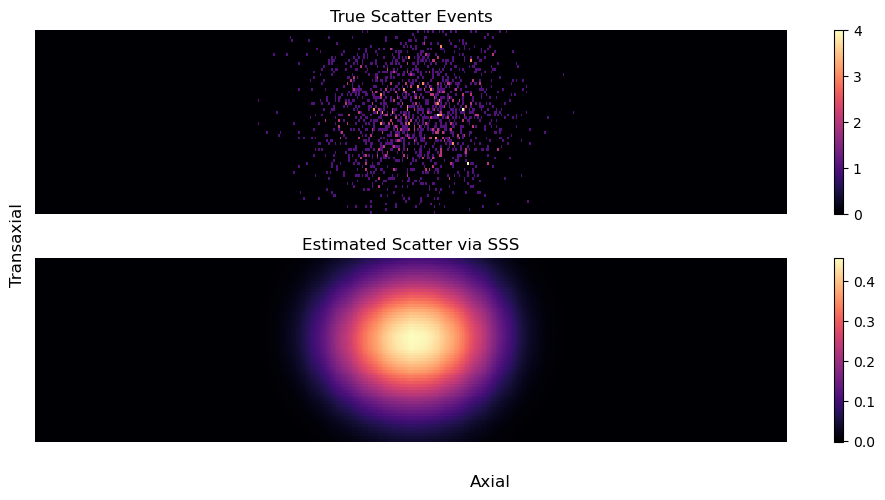

In [21]:
sinogram_scatters_true = gate.listmode_to_sinogram(detector_ids_scatters_true, info)

fig = plt.figure(figsize=(10,5))
plt.subplot(211)
plt.pcolormesh(sinogram_scatters_true[0,:,:64].T, cmap='magma')
plt.title('True Scatter Events')
plt.axis('off')
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(sinogram_scatter[0,:,:64].T, cmap='magma')
plt.title('Estimated Scatter via SSS')
plt.axis('off')
plt.colorbar()
fig.supxlabel('Axial')
fig.supylabel('Transaxial')
fig.tight_layout()
plt.show()

It's a little hard to validate on the sinograms since the true scatter data is sparse. We can instead look at profiles by summing accross certain dimensions:

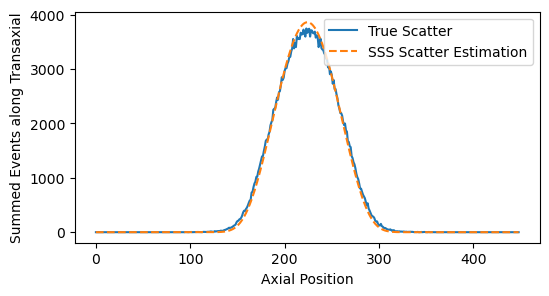

In [22]:
plt.figure(figsize=(6,3))
plt.plot(sinogram_scatters_true[:,:,:64].sum(dim=(0,2)), label='True Scatter')
plt.plot(sinogram_scatter[:,:,:64].sum(dim=(0,2)), ls='--', label='SSS Scatter Estimation')
plt.xlabel('Axial Position')
plt.ylabel('Summed Events along Transaxial')
plt.legend()
plt.show()

Now that we have the scatter sinogram estimate. The additive term to the likelihood is the sum of randoms+scatters divided by the sensitivty sinogram

In [23]:
additive_term = (sinogram_randoms_estimate + sinogram_scatter) / system_matrix._compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_sinogram_noTOF = recon_algorithm(2,24)

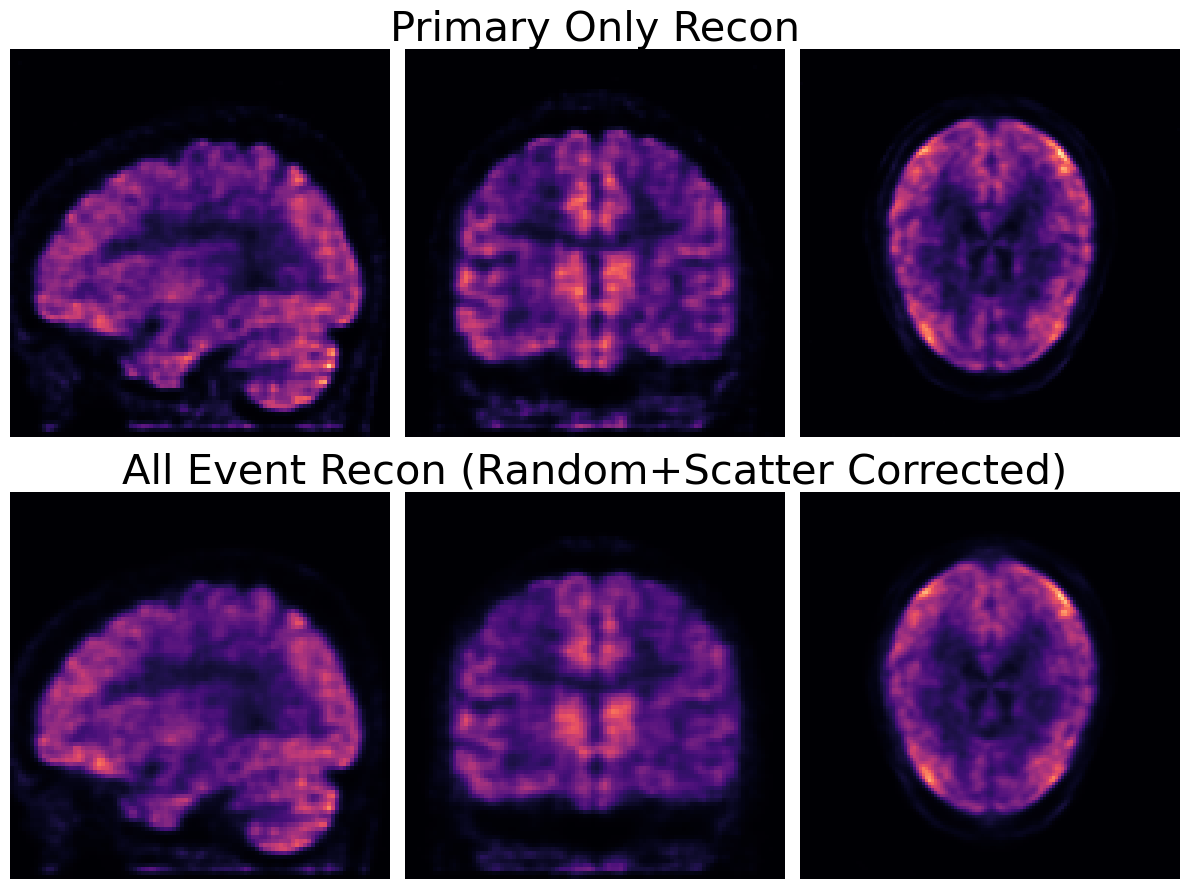

In [24]:
vmax = 0.15
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_sinogram_noTOF[48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_sinogram_noTOF[16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_sinogram_noTOF[:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()